## **Projeto Transfer Learning - Bootcamp DIO Ciência de Dados Unimed-BH**

Este projeto tem por objetivo demonstrar a utilização de um algoritmo de transfer learning para classificar imagens a partir de uma quantidade relativamente baixa de amostras de treino. Em resumo, o transfer learning refere-se ao processo de aprimorar o conhecimento adquirido em um modelo para treinar outros modelos.

O projeto elaborado tem como referência o seguinte script:

https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb#scrollTo=92mQ2gMlYoZl

Para este projeto foi utilizada uma base de dados com imagens de cães e gatos, a qual encontra-se disponível em:

https://www.microsoft.com/en-us/download/details.aspx?id=54765


In [1]:
#Importando pacotes
%matplotlib inline


#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import os
import random
import numpy as np
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [2]:
## Acessando Google Drive para importacao das bases de dados
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Carregando a base de dados Cats and Dogs

In [3]:
# Definindo o diretório com as bases de dados e determinando os parâmetros de treino

root = '/content/drive/MyDrive/Bootcamp_DIO_Unimed-BH/PetImages/'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['/content/drive/MyDrive/Bootcamp_DIO_Unimed-BH/PetImages/Cat', '/content/drive/MyDrive/Bootcamp_DIO_Unimed-BH/PetImages/Dog']


A função abaixo é utilizada para pre-processar os dados em uma imagem e inserir um vetor

In [4]:
def get_image(path):
    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregando todas as imagens do diretório

In [5]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# Contabilizando o número de classes (neste caso 2: cães e gatos)
num_classes = len(categories)

Randomizando a ordem dos dados

In [6]:
random.shuffle(data)

Criando training / validation / test split (70%, 15%, 15%)

In [7]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separando os dados para definir os labels (categorias)

In [8]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 

Normalizando os dados (float32) entre 0 e 1

In [9]:
# Normalizando dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convertendo labels para vetores (one-hot)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(750, 2)


Avaliando o resumo do que foi elaborado até aqui.

In [10]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 4998 images from 2 categories
train / validation / test split: 3498, 750, 750
training data shape:  (3498, 224, 224, 3)
training labels shape:  (3498, 2)


Se tudo funcionou devidamente, as imagens foram carregadas e divididas em três amostras: treino, validação e teste. A amostra de treino deve ter o formato (n, 224, 224, 3), onde n é o tamanho do grupo de teste (neste caso 3498 imagens). Na saída 'training labels shape' é possível verificar que estas 3498 imagens estão divididas em 2 categorias.


Consultando uma pequena amostra da base de dados.

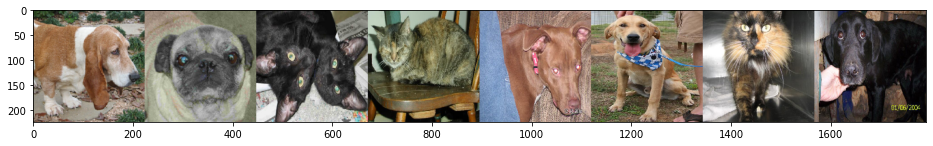

In [12]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [tf.keras.utils.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### **Treinando uma rede neural**

Antes de realizar o 'transfer learning', vamos construir uma rede neural para classificar nossa base de dados. Este procedimento fornece uma referência para comparar com nossa rede 'transfer-learned' posteriormente.


In [13]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

Como observado na saída, foi criada uma rede com aproximadamente 1.2 milhões de parâmetros. A partir disso, foi possível seguir com o treinamento do nosso modelo para 6 'epochs' com um tamanho de lote de 128, salvando o histórico para plotar a perda ao longo do tempo.


In [14]:
# Compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=6,
                    validation_data=(x_val, y_val))


Epoch 1/6
28/28 [==============================] - 225s 8s/step - loss: 0.6935 - accuracy: 0.5123 - val_loss: 0.6710 - val_accuracy: 0.6080
Epoch 2/6
28/28 [==============================] - 224s 8s/step - loss: 0.6568 - accuracy: 0.6029 - val_loss: 0.6465 - val_accuracy: 0.6013
Epoch 3/6
28/28 [==============================] - 222s 8s/step - loss: 0.6341 - accuracy: 0.6284 - val_loss: 0.6406 - val_accuracy: 0.6147
Epoch 4/6
28/28 [==============================] - 224s 8s/step - loss: 0.6047 - accuracy: 0.6575 - val_loss: 0.6169 - val_accuracy: 0.6427
Epoch 5/6
28/28 [==============================] - 229s 8s/step - loss: 0.5703 - accuracy: 0.7007 - val_loss: 0.5821 - val_accuracy: 0.6853
Epoch 6/6
28/28 [==============================] - 226s 8s/step - loss: 0.5570 - accuracy: 0.6961 - val_loss: 0.5604 - val_accuracy: 0.7053


Plotando a validação das perdas e da acurácia ao longo do tempo.

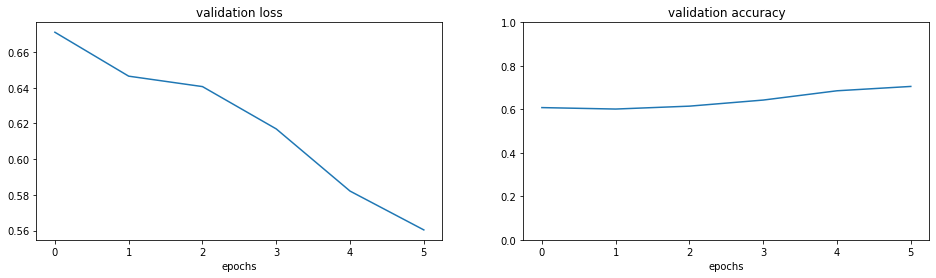

In [15]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [16]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5504176020622253
Test accuracy: 0.7239999771118164


### **Realizando o transfer learning a partir de uma rede existente**

Agora podemos seguir com o objetivo de treinar um classificador de imagens em nossa base de dados utilizando uma maior e já treinada rede neural.


In [17]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 9s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [18]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [19]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=2, 
                         validation_data=(x_val, y_val))


Epoch 1/2
28/28 [==============================] - 2265s 81s/step - loss: 0.2949 - accuracy: 0.8842 - val_loss: 0.3130 - val_accuracy: 0.8627
Epoch 2/2
28/28 [==============================] - 2272s 82s/step - loss: 0.2756 - accuracy: 0.8877 - val_loss: 0.2930 - val_accuracy: 0.8853


A acurácia da validação foi de aproximadamente 88%, sendo 16% superior à rede treinada originalmente.

Vamos plotar abaixo a validação da perda e da acurácia novamente, desta vez comparando o modelo treinado original (em azul) com o novo modelo transfer-learned (em laranja).

Obs.: Devido ao limite de memória do Colab, foram utilizadas somente 2 epochs no modelo transfer-learned

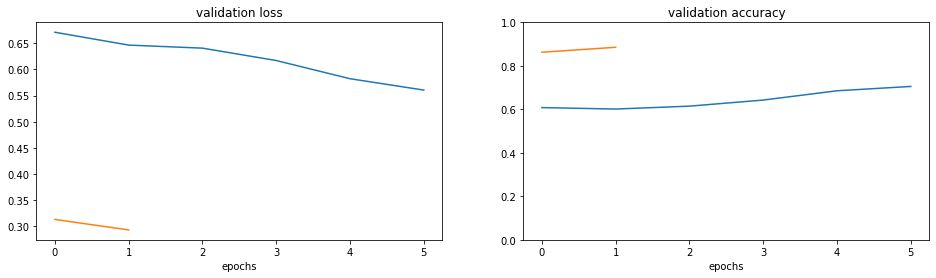

In [22]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Novamente, realizamos uma validação final da amostra de teste.

In [23]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.25991806387901306
Test accuracy: 0.8960000276565552
